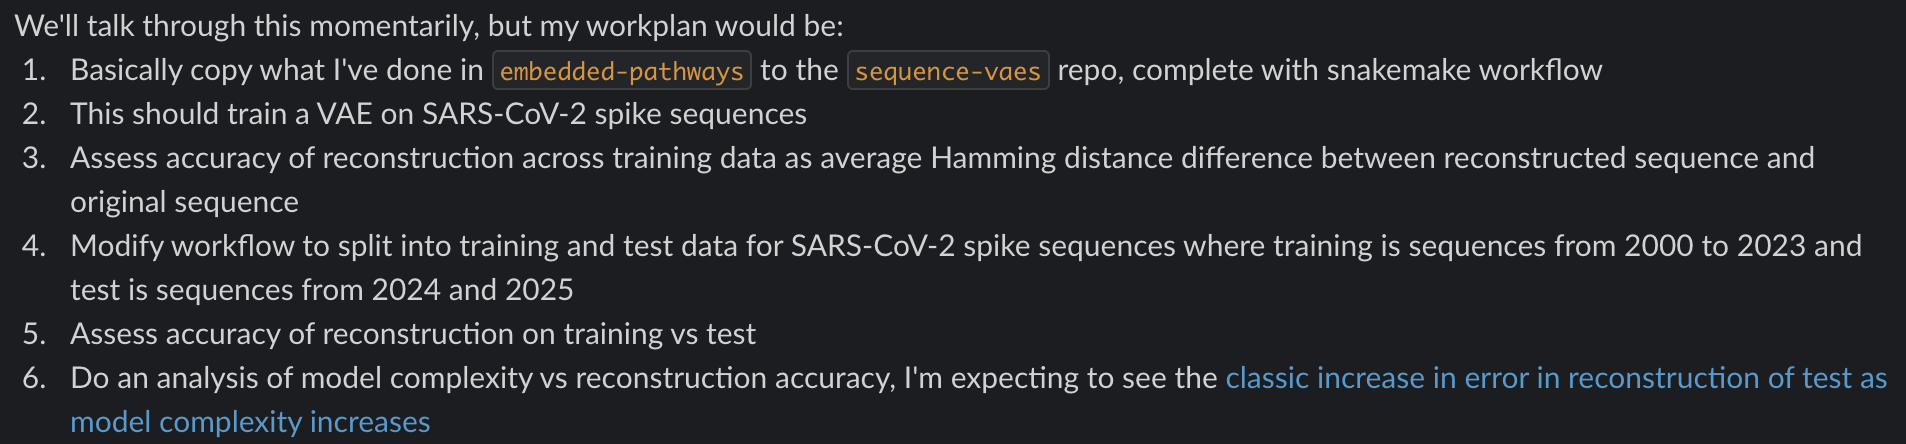

In [1]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [2]:
# path to sequence_vaes directory
# abspath = "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
abspath = ".."

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json

# path to sequence_vaes directory and pip install
# %cd "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
# !pip install -r requirements.txt

In [4]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

In [5]:
BATCH_SIZE = 64

# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/data/training_spike.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## loss figures

In [7]:
train_logs = []
valid_logs = []
with open("./results/train_logs.json", "r") as f:
    train_logs = json.load(f)[4:]

with open("./results/valid_logs.json","r") as f:
    valid_logs = json.load(f)[4:]

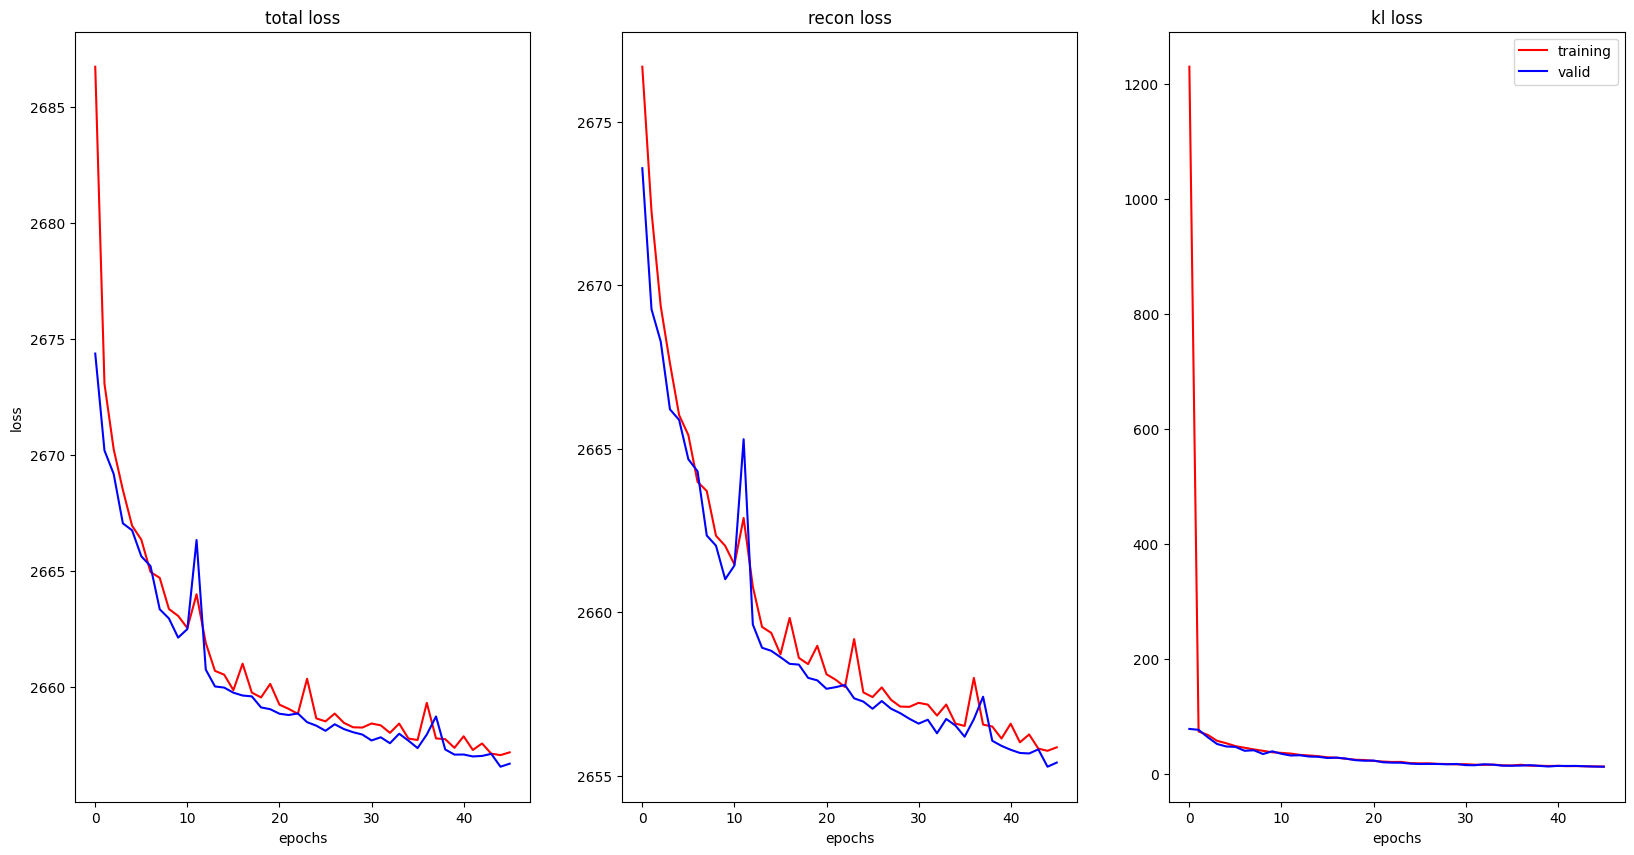

In [8]:
labels = ["total", "recon", "kl"]
colors = ["red", "blue"]

fig,arr = plt.subplots(1,3,figsize=(20,10))

N = len(train_logs)
for i in range(3):
    arr[i].plot(list(range(N)), [x[i] for x in train_logs], color=colors[0], label="training")
    arr[i].plot(list(range(N)), [x[i] for x in valid_logs], color=colors[1], label="valid")
    arr[i].set_title("%s loss"%labels[i])
    arr[i].set_xlabel("epochs")
    if i == 0:
        arr[i].set_ylabel("loss")

plt.legend()
fig.show()

## Embedding space Visualizations

In [7]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903
vae_model = VAE(input_dim=input_dim, latent_dim=50).to(DEVICE)
vae_model.load_state_dict(torch.load("./model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))
vae_model.eval()

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


VAE(
  (non_linear_activation): ReLU()
  (encoder): Encoder(
    (non_linear_activation): ReLU()
    (encode): Sequential(
      (0): Linear(in_features=19110, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): ReLU()
    (means): ModuleList(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=19110, bias=True)
    )
  )
)

In [81]:
dset = "valid"
abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
vals = np.array([dataset[x][1] for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/all_data/all_metadata.tsv", sep="\t")
# vals = []
# with open(f"{abspath}/data/{dset}/{dset}_aligned.fasta", "r") as f:
#   doc = f.readlines()
#   for d in doc:
#     if ">" == d[0]:
#       vals.append(d[1:])
# vals = [x.strip() for x in vals]
clade_labels = [metadata.loc[metadata.name == vals[i], "clade_membership"].values[0] for i in range(len(vals))]

In [82]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.clade_membership == c]) > 5:
        good_clade_labels.append(c)
print(set(good_clade_labels))

{'21J (Delta)', '20H (Beta)', '20I (Alpha)', '22C (BA.2.12.1)', '20J (Gamma)', '21I (Delta)', '22A (BA.4)', '22B (BA.5)', '22D (BA.2.75)', '21A (Delta)', '21K (BA.1)', '21L (BA.2)'}


In [83]:
# print(set(clade_labels))

clusters = np.array(list(set(good_clade_labels)))
print(clusters)
get_clade = lambda x: [True if elem == x else False for elem in clade_labels]

indexes = tuple([np.arange(len(clade_labels))[get_clade(x)] for x in clusters])

['21J (Delta)' '20H (Beta)' '20I (Alpha)' '22C (BA.2.12.1)' '20J (Gamma)'
 '21I (Delta)' '22A (BA.4)' '22B (BA.5)' '22D (BA.2.75)' '21A (Delta)'
 '21K (BA.1)' '21L (BA.2)']


In [84]:
new_vals = []
for v in vals:
    if metadata.loc[metadata.name == v, "clade_membership"].values[0] in clusters:
        new_vals.append(v)

In [85]:
parents = pd.read_csv(f"{abspath}/data/all_data/all_branches.tsv", sep="\t")
node_dict = {x:i for i,x in enumerate(new_vals)}
pairs = []
for p,c in zip(parents["parent"], parents["child"]):
    i1 = node_dict.get(p, None)
    i2 = node_dict.get(c, None)

    if i1 and i2:
        pairs.append((i1,i2))

pairs = np.array(pairs)

(360, 3822, 5)
torch.Size([356, 3822, 5])
(356, 19110)
[0.94242427 0.04779628]
total variance: 0.9902205476545489

----------------

[0.5142378 0.309939 ]
total variance: 0.8241767883300781

[0.9821774 0.0156484]
total variance: 0.9978258013725281


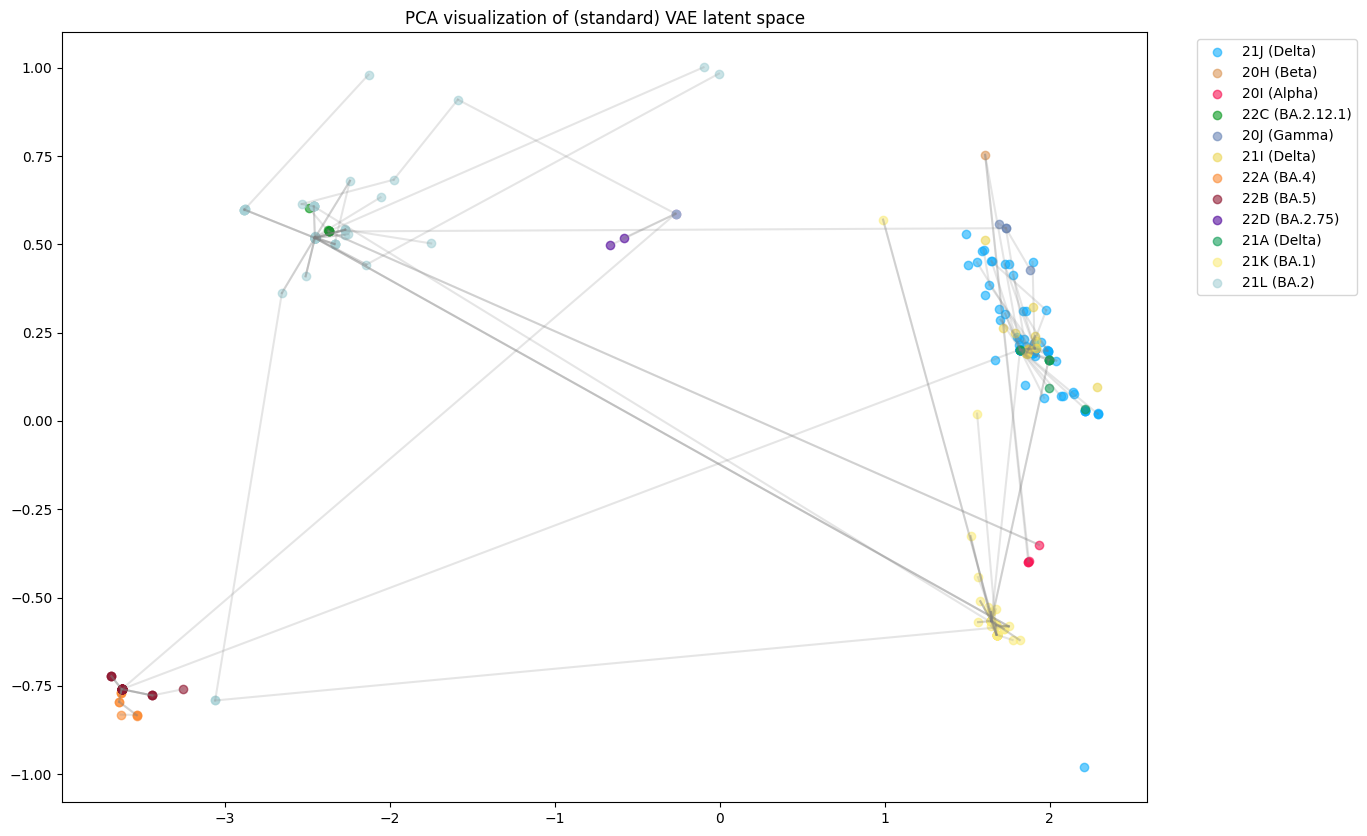

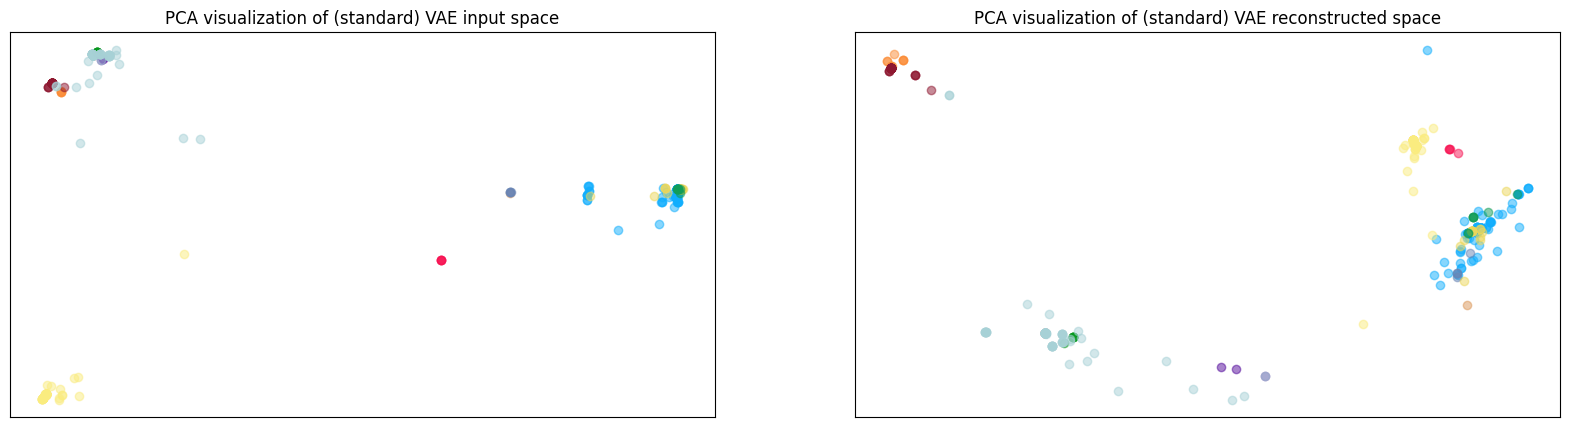

In [86]:
import matplotlib.colors as mcolors
import random
# colors = list(mcolors.TABLEAU_COLORS.keys())

random.seed(10)
colors = []
for i in range(len(indexes)):
    colors.append('#%06X' % random.randint(0, 0xFFFFFF))

ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset[ranges,:,:])
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
pca = PCA(n_components=2, svd_solver="full")

fig,ax = plt.subplots(1,1,figsize=(14,10))
recon = None
with torch.no_grad():
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()
    recon = vae_model.decoder.forward(Z_mean.to(DEVICE)).cpu().numpy()
    print(recon.shape)
    
    # Z_embedded = tsne(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X = Z_mean)
    pca.fit(Z_mean)
    Z_embedded = pca.transform(Z_mean)
    variances = pca.explained_variance_ratio_
    tot = np.sum(variances)
    print(variances)
    print(f"total variance: {tot}")
    curr = 0
    for i,arr in enumerate(indexes):
        loc_arr = list(range(curr,curr + len(arr),1))
        # print(set([clade_labels[x] for x in ranges[loc_arr]]))
        ax.scatter(Z_embedded[loc_arr,0], Z_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.6, color=colors[i])
        curr += len(arr)

    for p in pairs:
        ax.plot(Z_embedded[p,0], Z_embedded[p,1], color="gray", alpha=0.2)

l1 = 0.1
l2 = 0
ax.set_title("PCA visualization of (standard) VAE latent space")
ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

fig,ax = plt.subplots(1,2,figsize=(20,5))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.axis("on")

ax[0].set_title("PCA visualization of (standard) VAE input space")
print("\n----------------\n")
pca = PCA(n_components=2)
pca.fit(X=X.cpu().numpy())
X_embedded = pca.transform(X=X.cpu().numpy())
variances = pca.explained_variance_ratio_
tot = np.sum(variances)
print(variances)
print(f"total variance: {tot}\n")
curr = 0
for i,arr in enumerate(indexes):
    loc_arr = list(range(curr,curr + len(arr),1))
    ax[0].scatter(X_embedded[loc_arr,0], X_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
    curr += len(arr)

ax[1].set_title("PCA visualization of (standard) VAE reconstructed space")
pca = PCA(n_components=2)
pca.fit(X=recon)
recon_embedded = pca.transform(X=recon)
variances = pca.explained_variance_ratio_
tot = np.sum(variances)
print(variances)
print(f"total variance: {tot}")
curr = 0
for i,arr in enumerate(indexes):
    loc_arr = list(range(curr,curr + len(arr),1))
    ax[1].scatter(recon_embedded[loc_arr,0], recon_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
    curr += len(arr)
# ax[1].legend(bbox_to_anchor=(l1,l2,l1+1,l2+1)) 
plt.show()

In [92]:
import requests
response = requests.get("https://auspice.us/")

In [93]:
print(response.content)

b'<!doctype html><html><head><title>auspice</title><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"/><meta name="viewport" content="width=device-width,initial-scale=1"><link rel="shortcut icon" href="/favicon.png" type="image/png"><link rel="icon" href="/favicon.png" type="image/png"></head><body class="viewport"><div id="root"></div><script src="/dist/auspice.core-vendors.bundle.9d28f5f91c6e8cda8637.js"></script><script src="/dist/auspice.main.bundle.6d9def06e28eb152a8d7.js"></script></body></html>'


In [87]:
dset = "valid"

abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])

X = torch.tensor(new_dataset)
X_in = X.view(X.size(0), -1).to(DEVICE)
Z_mean, Z_logvar = vae_model.encoder.forward(X_in)

print(X.size(0))

genome = np.matmul(X.numpy(), np.array([1,2,3,4,5]))
print(X.size(1))
print(genome.shape[1])
hamming_dists = []
euclid_dists = []

for i in range(X.size(0)):
    for j in range(i+1, X.size(0)):
        ham_d = np.sum(np.not_equal(genome[i,:],genome[j,:]))
        euclid_d = torch.norm(Z_mean[i,:] - Z_mean[j,:]).cpu().detach()
        hamming_dists.append(ham_d)
        euclid_dists.append(euclid_d)



360
3822
3822


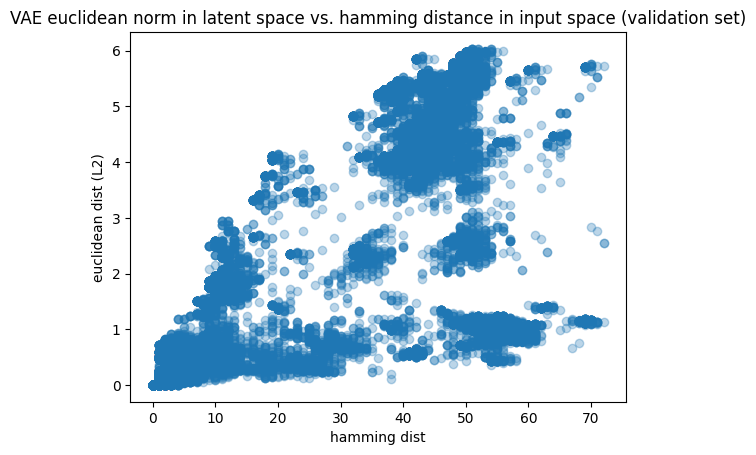

In [88]:
plt.scatter(hamming_dists, euclid_dists, alpha=0.3)
plt.title("VAE euclidean norm in latent space vs. hamming distance in input space (validation set)")
plt.xlabel("hamming dist")
plt.ylabel("euclidean dist (L2)")
plt.show()

In [89]:
print(np.corrcoef(np.vstack((euclid_dists, hamming_dists)))[1,0])

0.5664426263843495
